# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

# custom

# used to onehot encode during ROC/AUC calculation
import sklearn.preprocessing as preproc

# used to generate normalized confusion matrix
import itertools

# library used for SmoothGrad run
import saliency.core as saliency

In [2]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [3]:
from mnist1d_utils import *

# Dataset

In [4]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Show some examples from the MNIST 1-D dataset

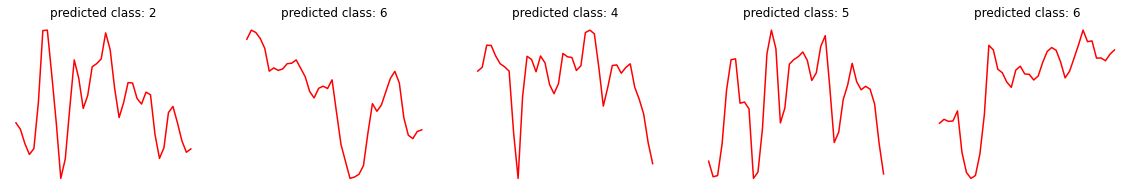

In [5]:
plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]));

plt.savefig('mnist_data_ex.png')

Show the digit templates in the MNIST 1-D dataset 

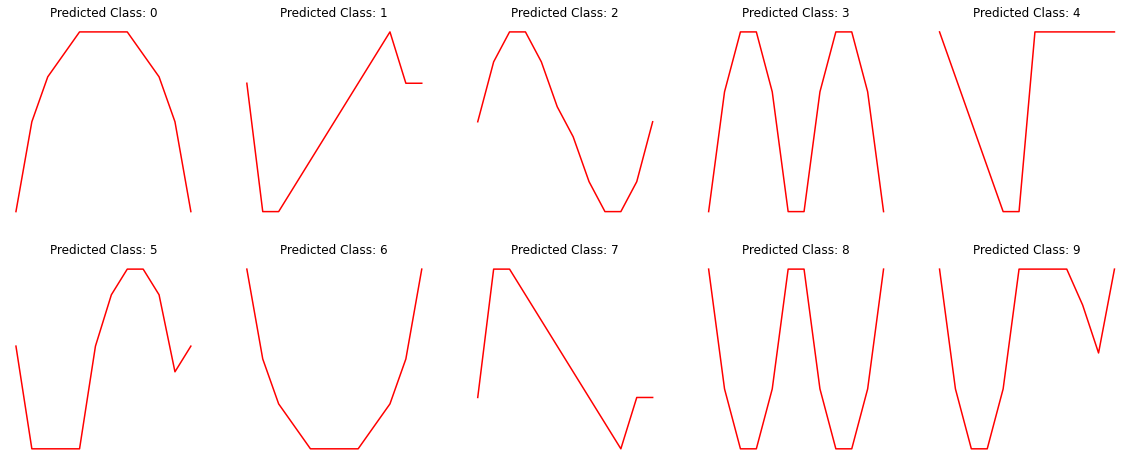

In [33]:
plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('Predicted Class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('Predicted Class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('Predicted Class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('Predicted Class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('Predicted Class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('Predicted Class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('Predicted Class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('Predicted Class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('Predicted Class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('Predicted Class: 9');

plt.savefig('mnist_templates.png')

Save the dataset

In [7]:
with open("MNIST1D_dataset.pkl","wb") as f:
    pickle.dump(dataset,f)

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

The sequential model was created as per the instructions in Figure 1 of the project handout

In [8]:
##Task1-Question1

# Given Code
weight_decay = 5e-4
model = Sequential()

# Project Code
# largely adapted from https://www.tensorflow.org/tutorials/images/cnn

num_classes = dataset['templates']['x'].shape[0] # 10 classes
# Input shape based on the size of the input data; each input to the model is a size-40 array with a single 
# datapoint per timestep (like in a greyscale image), so input shape comes out to (40,1)
input_shape = (dataset['x'].shape[1], 1)

# first/input layer - CONV1D layer with 25 filter channels, a 5x5 kernel size, single stride,'same' padding and ReLU activation. 
model.add(Conv1D(filters=25, kernel_size=5, strides=1, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(weight_decay), 
                 input_shape=input_shape)) 
# second layer - CONV1D layer with 25 filter channels, a 3x3 kernel size, single stride, 'same' padding and ReLU activation. 
model.add(Conv1D(filters=25, kernel_size=3, strides=1, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(weight_decay)))
# third layer - same parameters as the second layer
model.add(Conv1D(filters=25, kernel_size=3, strides=1, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(weight_decay)))
# fourth layer - Flatten
model.add(Flatten())
# fifth/final layer - Dense layer with softmax activation
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay)))

print(model.summary())
##

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________
None


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [13]:
##Task1-Question2

# Project Code
# Largely adapted from https://www.tensorflow.org/tutorials/images/cnn

model.compile(optimizer='sgd', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy']) #sparse categorial chosen to use integer labels

fit_output = model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, epochs=200)

# Save the model
model.save('MNIST1D.h5')

# Dump the fit history
with open('log/train/mnist_history.pkl', 'wb') as f:
    pickle.dump(fit_output.history, f)
##

Epoch 1/200


c:\users\nich_\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 5s 10ms/step - loss: 2.3335 - accuracy: 0.1311 - val_loss: 2.3298 - val_accuracy: 0.1225
Epoch 2/200
113/113 [==============================] - 1s 6ms/step - loss: 2.3214 - accuracy: 0.1442 - val_loss: 2.3151 - val_accuracy: 0.1375
Epoch 3/200
113/113 [==============================] - 1s 6ms/step - loss: 2.2943 - accuracy: 0.1667 - val_loss: 2.2725 - val_accuracy: 0.1575
Epoch 4/200
113/113 [==============================] - 1s 5ms/step - loss: 2.2169 - accuracy: 0.1839 - val_loss: 2.1556 - val_accuracy: 0.2075
Epoch 5/200
113/113 [==============================] - 1s 6ms/step - loss: 2.0393 - accuracy: 0.2389 - val_loss: 1.9647 - val_accuracy: 0.2275
Epoch 6/200
113/113 [==============================] - 1s 8ms/step - loss: 1.8670 - accuracy: 0.2689 - val_loss: 1.8343 - val_accuracy: 0.2825
Epoch 7/200
113/113 [==============================] - 1s 6ms/step - loss: 1.7753 - accuracy: 0.2992 - val_loss: 1.7907 - val_accuracy: 0.2575
Epoch 8/20

# Plotting the training progress

In [10]:
# Load the model and history

with open('log/train/mnist_history.pkl', 'rb') as f:
    history = pickle.load(f)

model=load_model('models/MNIST1D.h5')

# for redundancy/to avoid retraining the model
num_classes = dataset['templates']['x'].shape[0] # 10 classes

**Training Accuracy/Loss**

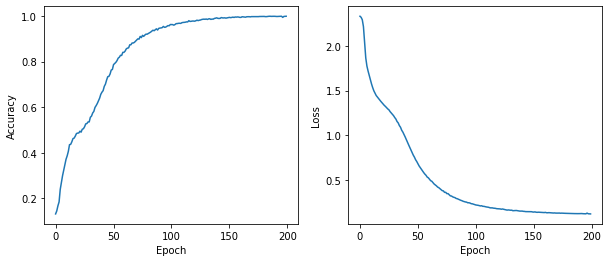

In [11]:
# Task 1.3.a
# Plot the generated figures from the fit history
plt.figure(figsize=(10,4))

# Accuracy vs. Epoch
plt.subplot(121)
plt.plot(history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss vs. Epoch
plt.subplot(122)
plt.plot(history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

plt.savefig('mnist_acc_loss.png')

**Overall Classification Accuracy**

In [12]:
# Task 1.3.b
# Evaluate the model's performance on the entire test dataset and output the reported accuracy

accuracy = model.evaluate(x=np.expand_dims(dataset['x_test'], axis=-1), y=dataset['y_test'])[1]
print(f'Overall model accuracy: {accuracy:.4f}')

32/32 [==============================] - 3s 4ms/step - loss: 1.3079 - accuracy: 0.8770
Overall model accuracy: 0.8770


**Classwise Classification Accuracy**

In [13]:
# Task 1.3.c
# Evaluate the model's performance on the segregated test datasets for each different class 
# and output the reported accuracy for each, in the same method as the previous task

Create classwise datasets

In [14]:
class_dataset = dict()
for idx in range(num_classes):
    class_dataset[idx] = dict()
    class_dataset[idx]['x'] = []
    class_dataset[idx]['y'] = []
    for c_idx in range(0, dataset['x_test'].shape[0]):
        if dataset['y_test'][c_idx] == idx:
            class_dataset[idx]['x'].append(dataset['x_test'][c_idx])
            class_dataset[idx]['y'].append(dataset['y_test'][c_idx])
    class_dataset[idx]['x'] = np.asarray(class_dataset[idx]['x'])
    class_dataset[idx]['y'] = np.asarray(class_dataset[idx]['y'])

Evaluate the model on each dataset and output the results

In [15]:
accuracy = []
for idx in range(num_classes):
    accuracy.append(model.evaluate(x=np.expand_dims(class_dataset[idx]['x'], axis=-1), y=class_dataset[idx]['y'])[1])
print()
for idx in range(num_classes):    
    print(f'Class {idx} model accuracy: {accuracy[idx]:.4f}')

4/4 [==============================] - 0s 3ms/step - loss: 1.7809 - accuracy: 0.7843

Class 0 model accuracy: 0.9804
Class 1 model accuracy: 0.8077
Class 2 model accuracy: 0.8876
Class 3 model accuracy: 0.9434
Class 4 model accuracy: 0.8491
Class 5 model accuracy: 0.8163
Class 6 model accuracy: 0.9192
Class 7 model accuracy: 0.8646
Class 8 model accuracy: 0.9184
Class 9 model accuracy: 0.7843


**Classwise ROC/AUC**

In [16]:
# Task 1.3.d
# Run the model over the entire dataset to get the prediction results, and calculate
# the ROC for each class based on these. Get the AUC from the ROC.
# Largely adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

Get Model Predictions/Scores

In [17]:
# Also used for the Normalized Confusion Matrix

# One-hot encode the classes
y_test = preproc.label_binarize(dataset['y_test'], classes=dataset['templates']['y']) 

# Run the model and get the predictions as well as the classwise score
y_score = model.predict(x=np.expand_dims(dataset['x_test'], axis=-1))
y_pred = np.argmax(y_score, axis=1)

Generate ROC Plots and Calculated AUC

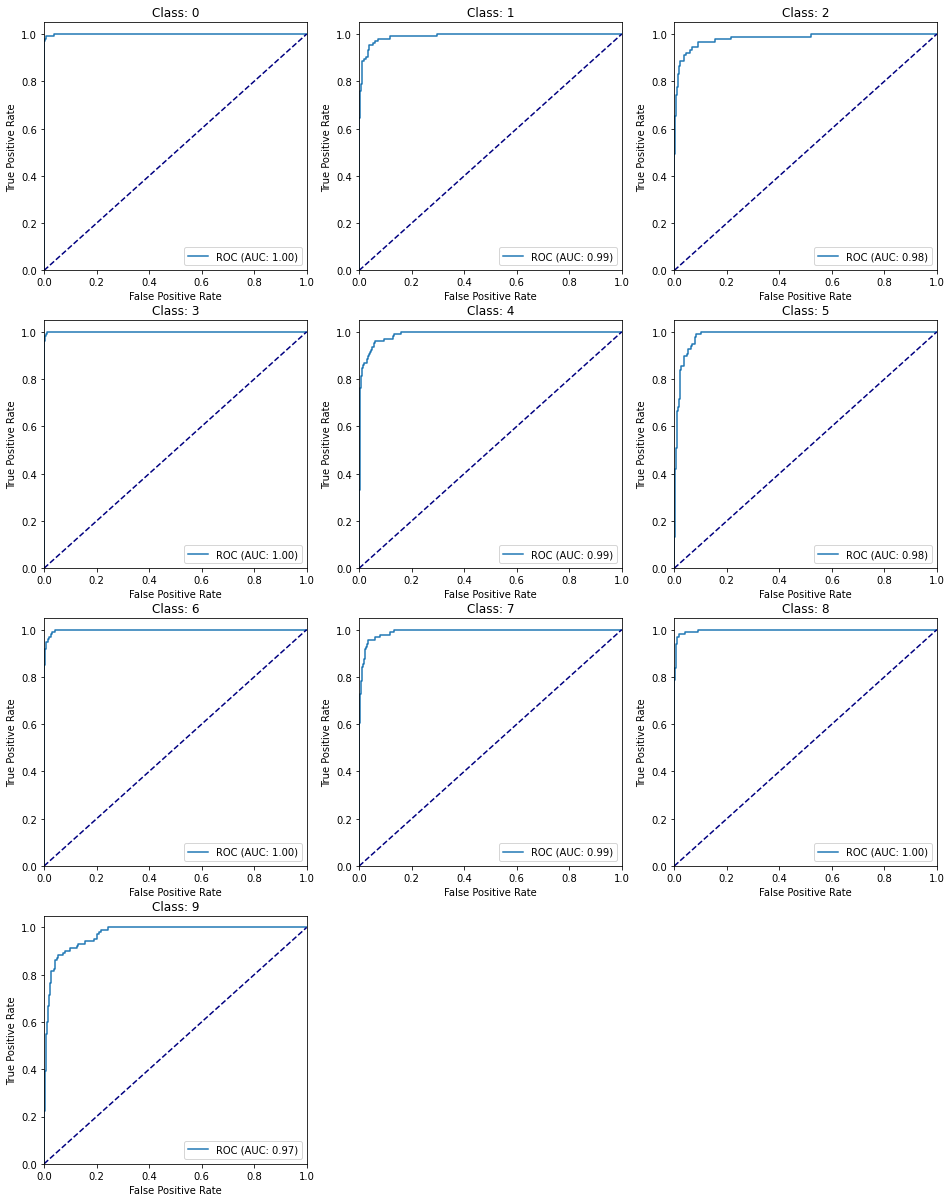

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(16,21))

for idx in range(dataset['templates']['y'].shape[0]):
    plt.subplot(4,3,idx + 1)
    
    fpr[idx], tpr[idx], _ = metrics.roc_curve(y_test[:, idx], y_score[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])
    
    plt.plot(fpr[idx], tpr[idx], label="ROC (AUC: %0.2f)" % roc_auc[idx])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class: {idx}')
    plt.legend(loc="lower right")
    
plt.savefig('mnist_roc_AUC.png')
plt.show()


**Normalized Confusion Matrix**

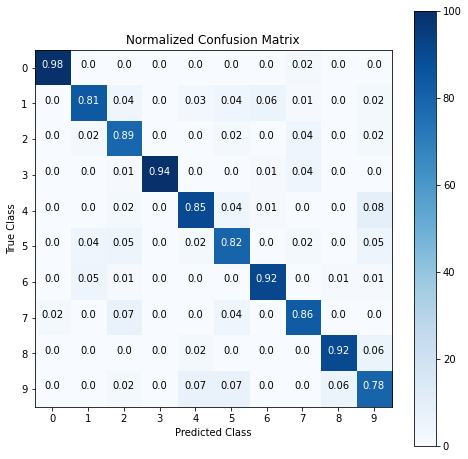

In [18]:
# Task 1.3.e
# Using the prediction data from the ROC/AUC generation above, generate the confusion matrix directly using tensorflow
# Plot the matrix/normalize the matrix values
# Largely adapted from https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

# Generate the matrix
base_cm = tensorflow.math.confusion_matrix(dataset['y_test'], y_pred, num_classes=10).numpy()

figure = plt.figure(figsize=(8, 8))
plt.imshow(base_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
plt.xticks(range(num_classes), dataset['templates']['y'])
plt.yticks(range(num_classes), dataset['templates']['y'])

# Normalize the confusion matrix.
norm_cm = np.around(base_cm.astype('float') / base_cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Use white text if squares are dark; otherwise black.
threshold = norm_cm.max() / 2.
for i, j in itertools.product(range(norm_cm.shape[0]), range(norm_cm.shape[1])):
    color = "white" if norm_cm[i, j] > threshold else "black"
    plt.text(j, i, norm_cm[i, j], horizontalalignment="center", color=color)

plt.ylabel('True Class')
plt.xlabel('Predicted Class');
plt.savefig('mnist_cm.png')

**Precision/Recall/F1**

In [19]:
# Task 1.3.f
# Using the generated confusion matrix, generate the precision and recall values, and from those the F1 scores for each class

# Precision/Recall/F-1
precision = []
recall = []
f_1 = []
for i in range(dataset['templates']['y'].shape[0]):
    precision.append(float(base_cm[i, i])/float(sum(base_cm[i, :])))
    recall.append(float(base_cm[i, i])/float(sum(base_cm[:, i])))
    f_1.append(2*precision[i]*recall[i]/(precision[i] + recall[i]))
    print(f'Class: {i}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1: {f_1[i]}')
    print()
    
print(f'Macro Precision: {sum(precision)/len(precision)}')
print(f'Macro Recall: {sum(recall)/len(recall)}')
print(f'Macro F1: {sum(f_1)/len(f_1)}')

Class: 0
Precision: 0.9803921568627451
Recall: 0.9803921568627451
F1: 0.9803921568627451

Class: 1
Precision: 0.8076923076923077
Recall: 0.8842105263157894
F1: 0.8442211055276383

Class: 2
Precision: 0.8876404494382022
Recall: 0.7821782178217822
F1: 0.831578947368421

Class: 3
Precision: 0.9433962264150944
Recall: 1.0
F1: 0.970873786407767

Class: 4
Precision: 0.8490566037735849
Recall: 0.8653846153846154
F1: 0.8571428571428571

Class: 5
Precision: 0.8163265306122449
Recall: 0.7920792079207921
F1: 0.8040201005025126

Class: 6
Precision: 0.9191919191919192
Recall: 0.9191919191919192
F1: 0.9191919191919192

Class: 7
Precision: 0.8645833333333334
Recall: 0.8645833333333334
F1: 0.8645833333333333

Class: 8
Precision: 0.9183673469387755
Recall: 0.9278350515463918
F1: 0.923076923076923

Class: 9
Precision: 0.7843137254901961
Recall: 0.7619047619047619
F1: 0.7729468599033817

Macro Precision: 0.8770960599748404
Macro Recall: 0.8777759790282129
Macro F1: 0.87680279893175


# Explanation

In [35]:
from xai_utils import *

Take a test sample

In [36]:
x_test = dataset['x_test']
y_test = dataset['y_test'];

Give the input to the model (Prediction)

In [37]:
#index = int(np.floor(np.random.rand()*1000))

correct_index = [414, 639, 625, 68, 962, 872, 892, 94, 918, 507]
fail_index = [856, 180, 556, 205, 459]

test_list = correct_index + fail_index

# the provided SISE code and the saliency library use different input formats, so I have split them here

sise_input = []
smoothgrad_input = []
label = []
prediction_class = []

for list_idx, index in enumerate(test_list):
    sise_input.append(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1))
    smoothgrad_input.append(x_test[index])
    label.append(y_test[index])
    prediction_class.append(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()))

    print(f'Correct digit: {label[list_idx]}')
    print(f'Predicted digit: {prediction_class[list_idx]}')
    print(f'Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label[list_idx]]))
    print()

Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 0.99710923

Correct digit: 1
Predicted digit: 1
Confidence score for the correct label: 0.94127446

Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 0.9882625

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 1.0

Correct digit: 4
Predicted digit: 4
Confidence score for the correct label: 0.96696454

Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 0.89572316

Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 0.99941015

Correct digit: 7
Predicted digit: 7
Confidence score for the correct label: 0.99784315

Correct digit: 8
Predicted digit: 8
Confidence score for the correct label: 1.0

Correct digit: 9
Predicted digit: 9
Confidence score for the correct label: 0.9971411

Correct digit: 8
Predicted digit: 9
Confidence score for the correct label: 0.26762033

Correct digit: 2
Predicted digit: 7
Confidence s

## SISE (Semantic Input Sampling for Explanation)

In [38]:
# Provided Code

In [39]:
sise_exp = []

for list_idx, __ in enumerate(test_list):
    sise_exp.append(SISE(sise_input[list_idx], model, label[list_idx], [['conv1d_2']], grad_thr=0.))

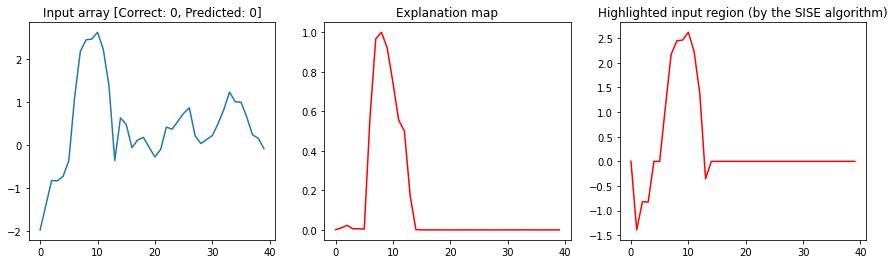

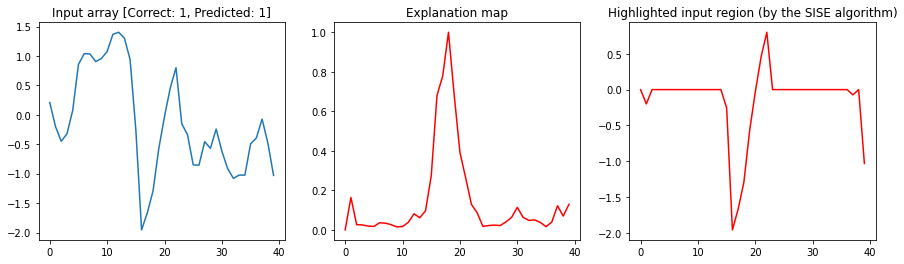

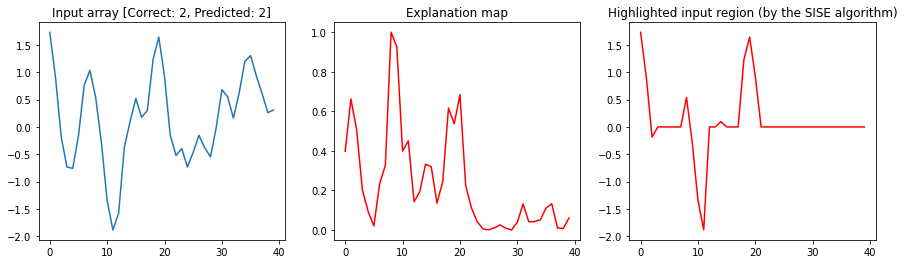

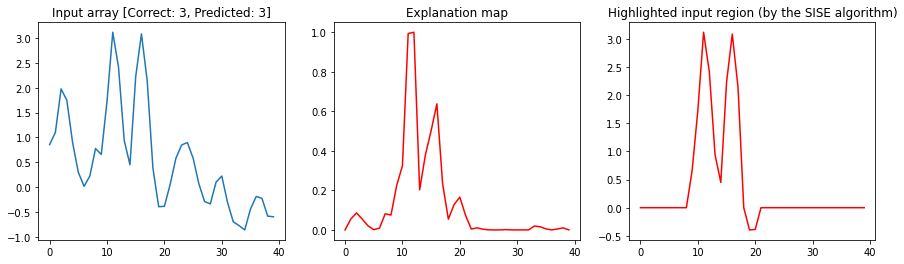

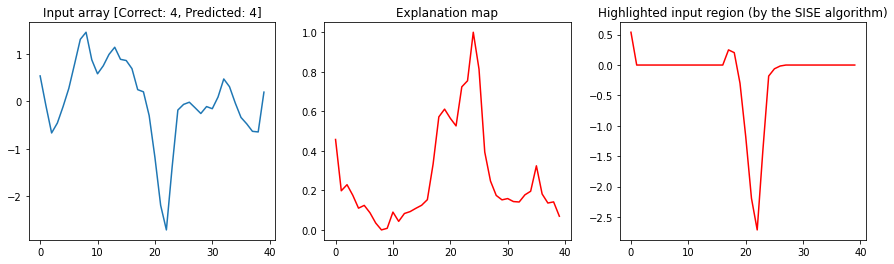

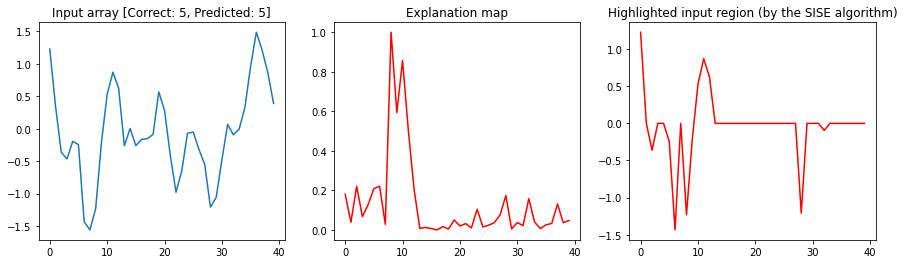

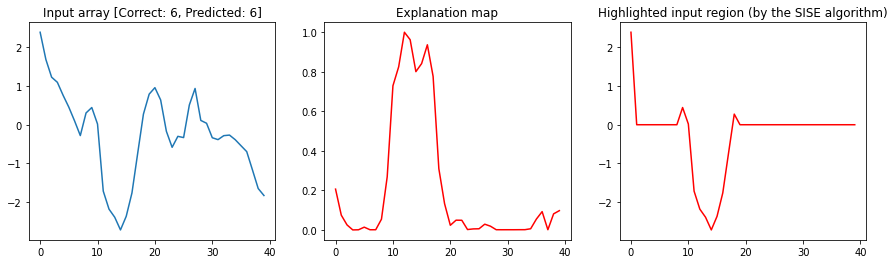

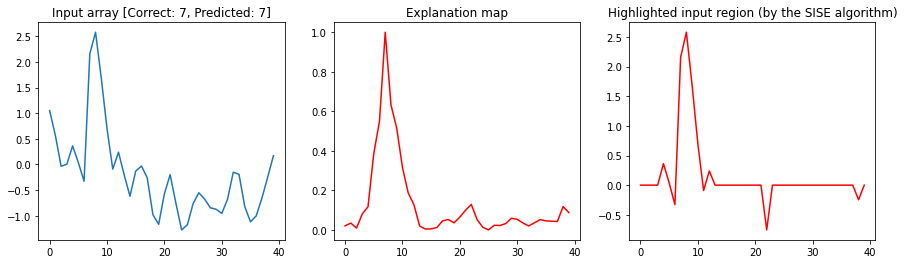

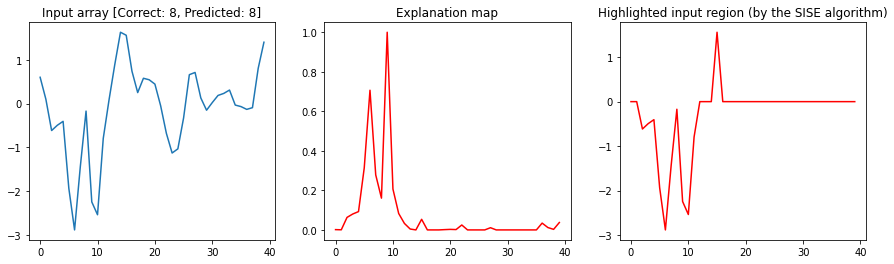

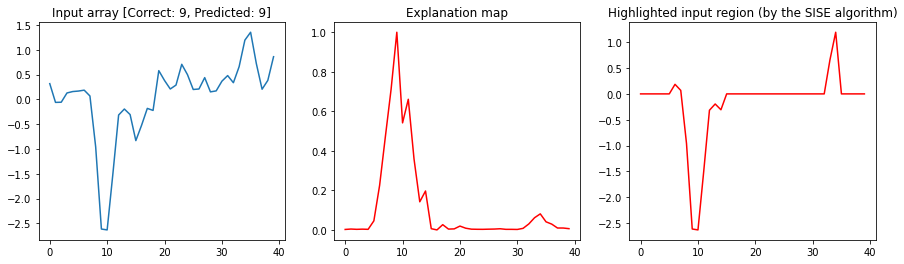

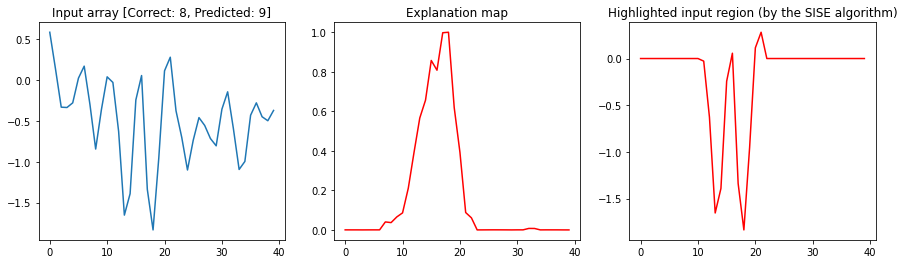

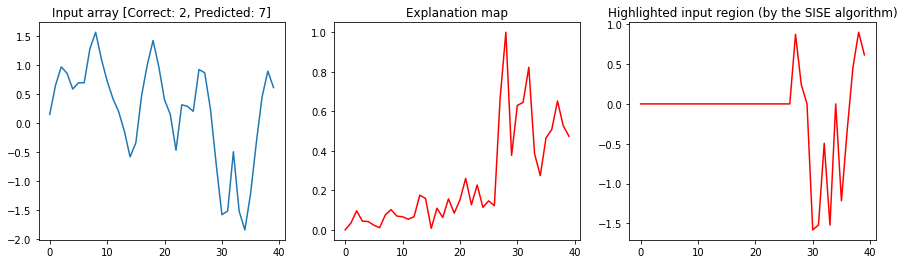

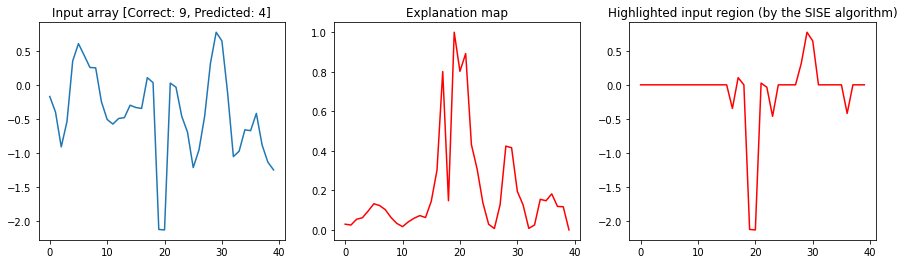

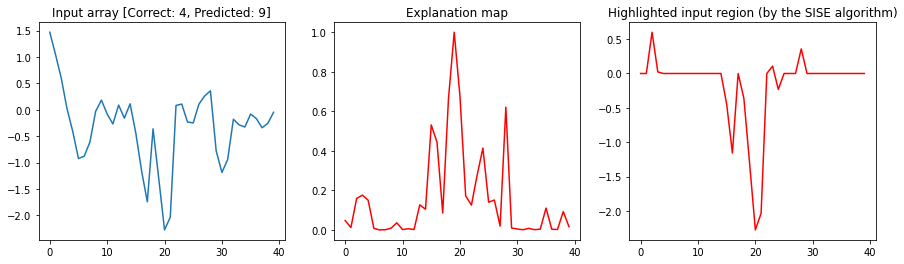

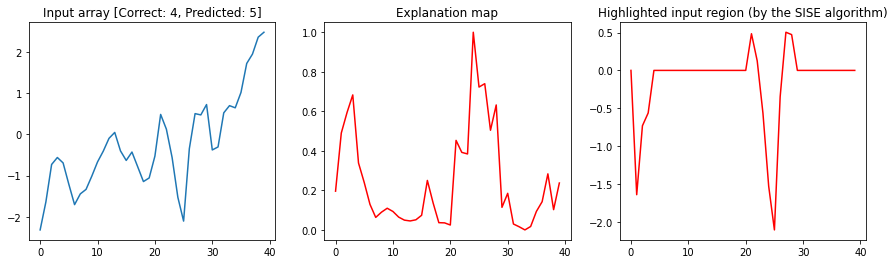

In [74]:
for list_idx, _ in enumerate(test_list):
    
    threshold = np.sort(sise_exp[list_idx][:,0])[-12]
    
    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.plot(sise_input[list_idx][0])
    plt.title(f'Input array [Correct: {label[list_idx]}, Predicted: {prediction_class[list_idx]}]')

    plt.subplot(1,3,2)
    plt.plot(sise_exp[list_idx], 'r')
    plt.title('Explanation map')

    #plt.subplot(2,2,3)
    #plt.plot(dataset['templates']['x'][label[list_idx]])
    #plt.title('Label template')

    plt.subplot(1,3,3)
    plt.plot((sise_input[list_idx][0]*(sise_exp[list_idx]>threshold)), 'r')
    plt.title('Highlighted input region (by the SISE algorithm)');
    plt.savefig(f'mnist_sise_{"correct" if list_idx < 10 else "incorrect"}_{label[list_idx]}.png')

## SmoothGrad

In [76]:
# Task 2.2 code
# Largely adapted from https://github.com/PAIR-code/saliency/blob/master/Examples_core.ipynb and https://www.tensorflow.org/api_docs/python/tf/GradientTape

# Generate the gradient object (no actual work done at this point)
gradient_saliency = saliency.GradientSaliency()

# Saliency callback function
# Calls back the model via the saliency library to calculate the gradients of the image
def call_model_function(data, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args['class_idx']
    data = tf.convert_to_tensor(data)
    # compute a single order gradient
    
    with tf.GradientTape() as g:

        g.watch(data)

        output_layer = model(data)
        output_layer = output_layer[:,target_class_idx]
        gradients = np.array(g.gradient(output_layer, data))
                                        
    return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

smoothgrad_exp = []

for list_idx, __ in enumerate(test_list):
    smoothgrad_exp.append(gradient_saliency.GetSmoothedMask(smoothgrad_input[list_idx], call_model_function, {'class_idx': prediction_class[list_idx]})); #1D array output
    # 'normalize' to 1 at peak to match SISE output
    smoothgrad_exp[list_idx] = smoothgrad_exp[list_idx]/max(smoothgrad_exp[list_idx])

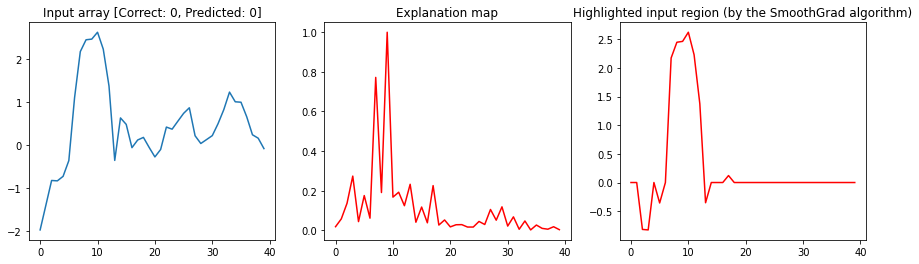

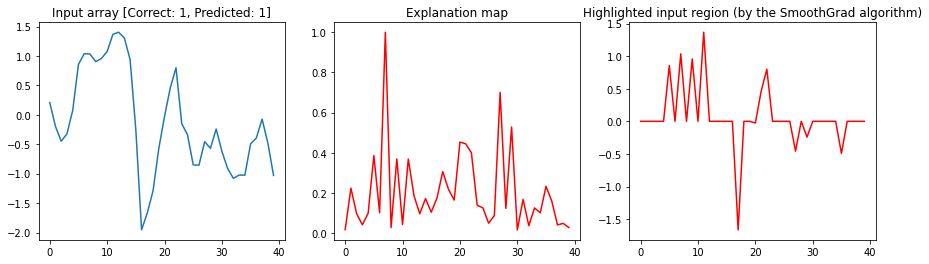

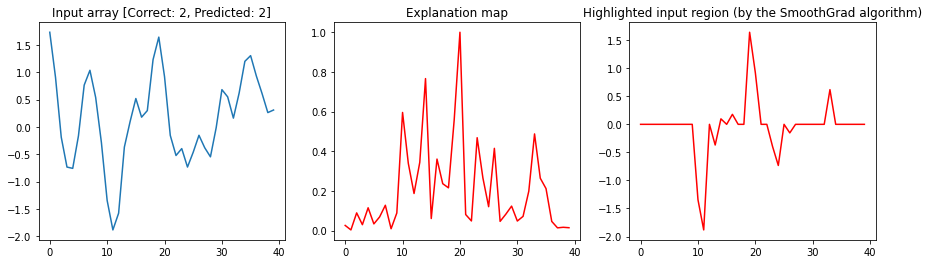

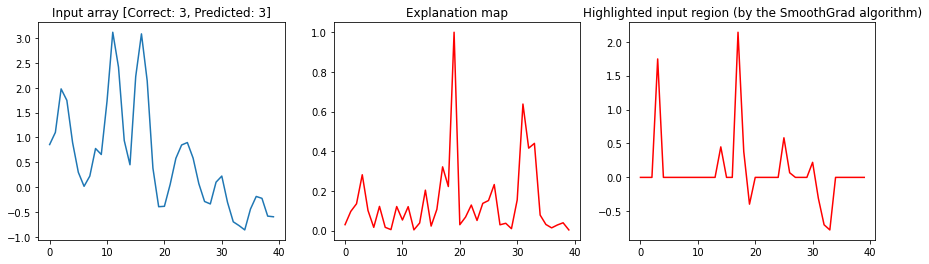

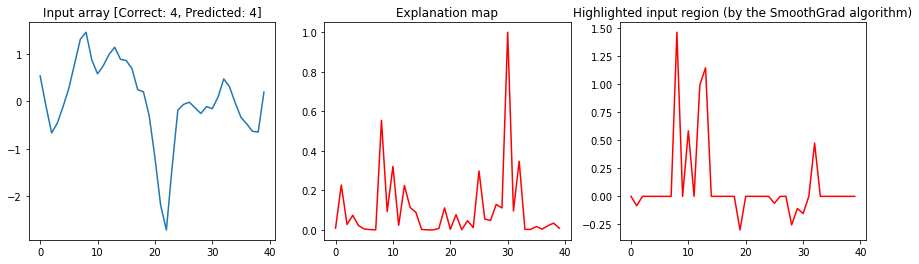

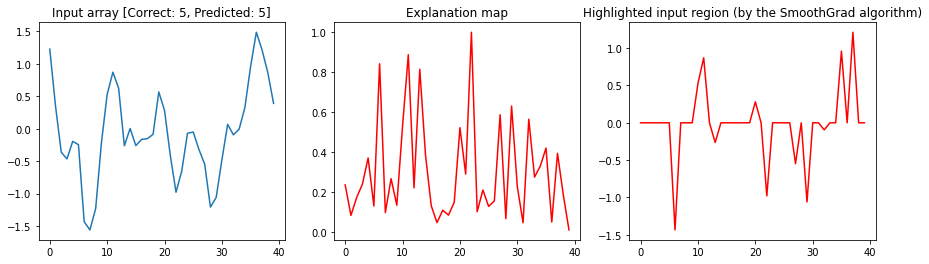

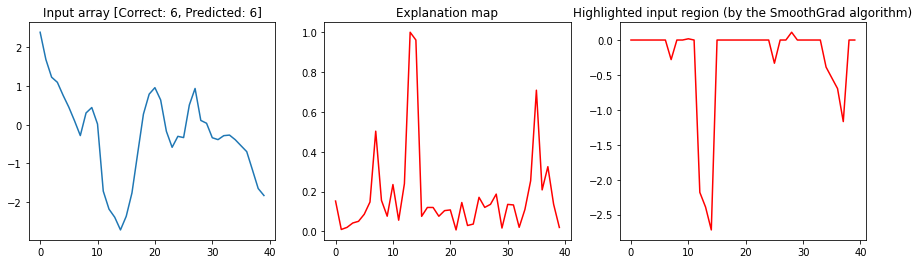

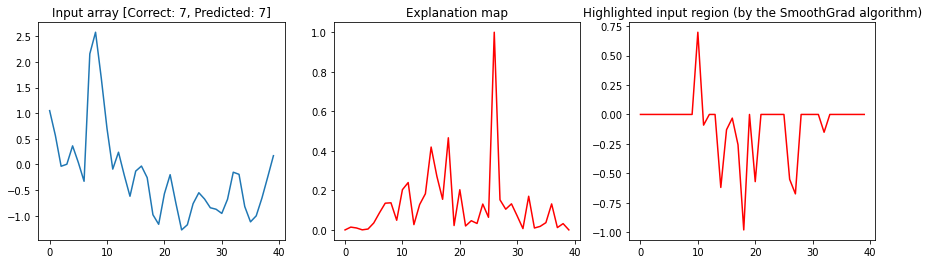

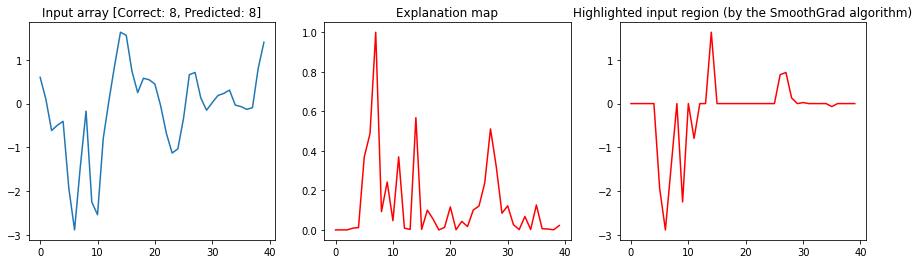

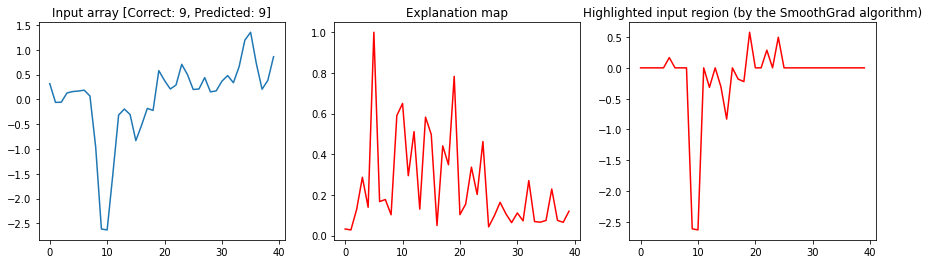

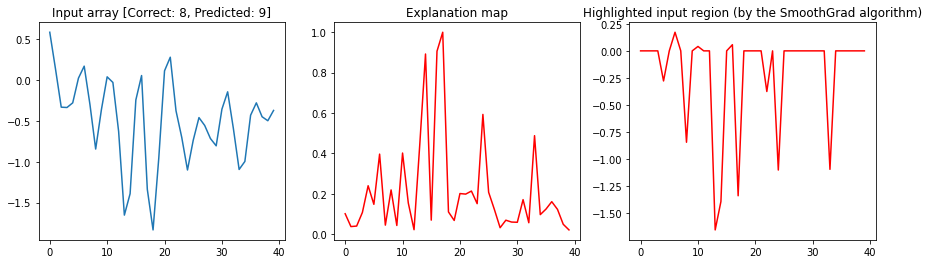

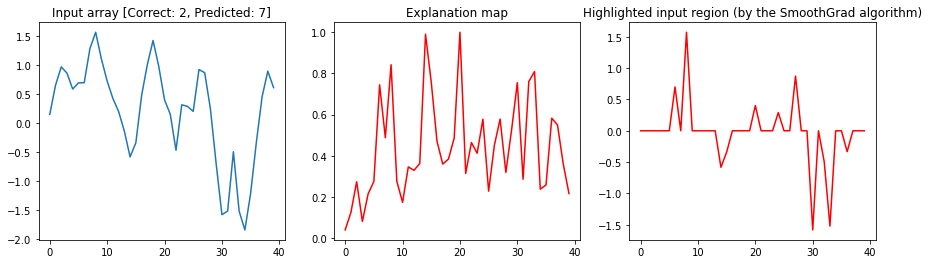

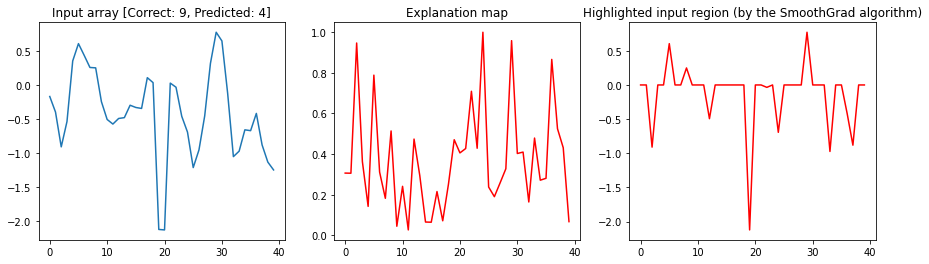

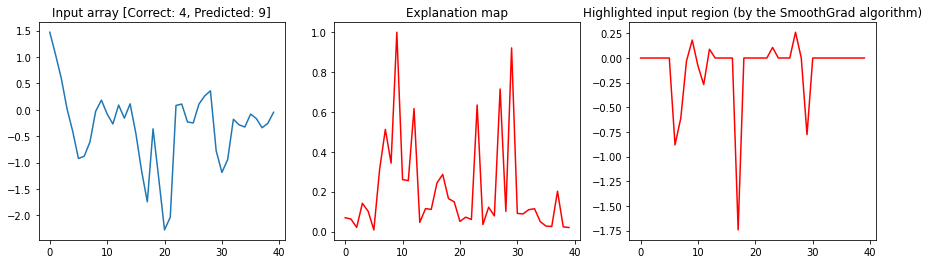

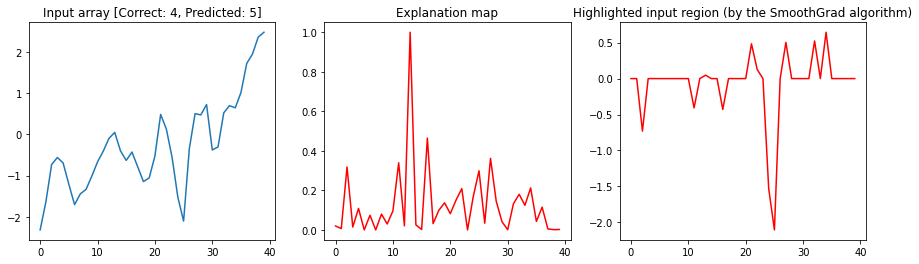

In [75]:
for list_idx, _ in enumerate(test_list):

    threshold = np.sort(smoothgrad_exp[list_idx])[-12]

    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.plot(smoothgrad_input[list_idx])
    plt.title(f'Input array [Correct: {label[list_idx]}, Predicted: {prediction_class[list_idx]}]')

    plt.subplot(1,3,2)
    plt.plot(smoothgrad_exp[list_idx], 'r')
    plt.title('Explanation map')

    #plt.subplot(2,2,3)
    #plt.plot(dataset['templates']['x'][label[list_idx]])
    #plt.title('Label template')

    plt.subplot(1,3,3)
    plt.plot((smoothgrad_input[list_idx]*(smoothgrad_exp[list_idx]>threshold)), 'r')
    plt.title('Highlighted input region (by the SmoothGrad algorithm)');
    plt.savefig(f'mnist_smoothgrad_{"correct" if list_idx < 10 else "incorrect"}_{label[list_idx]}.png')

## Quantitative evaluation

In [78]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [79]:
sise_drop_rate = 0.
sise_increase_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)

    drop_increase = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    sise_drop_rate += drop_increase[0]
    sise_increase_rate += drop_increase[1]
    
sise_drop_rate /= 1000
sise_increase_rate /= 1000
print(f'SISE Drop Rate: {sise_drop_rate}')
print(f'SISE Increase Rate: {sise_increase_rate}')

SISE Drop Rate: 0.13717405445392253
SISE Increase Rate: 0.374


In [80]:
smoothgrad_drop_rate = 0.
smoothgrad_increase_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()    
    explanation_map = gradient_saliency.GetSmoothedMask(x_test[index], call_model_function, {'class_idx': np.argmax(prediction[0])})
    
    # 'normalize' to 1 at peak to match SISE output amnd reformat to work with the calculate_drop_increase function
    explanation_map = explanation_map/max(explanation_map)
    explanation_map = np.expand_dims(explanation_map, axis=-1)
    
    drop_increase = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    smoothgrad_drop_rate += drop_increase[0]
    smoothgrad_increase_rate += drop_increase[1]
    
smoothgrad_drop_rate /= 1000
smoothgrad_increase_rate /= 1000
print(f'SmoothGrad Drop Rate: {smoothgrad_drop_rate}')
print(f'SmoothGrad Increase Rate: {smoothgrad_increase_rate}')

SmoothGrad Drop Rate: 0.5400397755495486
SmoothGrad Increase Rate: 0.128
